# Harry Neal - Spotify MoodGrid

*Spotify Moodgrid Playlist Subsetter is a tool to combine multiple playlists, give them a happy score and an energy score, and then output a new personal playlist centred around your chosen Happy/Energy mood.*

## Notebook 3 of 4 - Modelling

In [190]:
import numpy as np
import pandas as pd
import re
from collections import Counter

import joblib
import warnings
warnings.filterwarnings('ignore')

# For Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Baseline Model

In order to evaluate our model and gauge improvements, we will create a baseline prediction model.  This will use the raw unprocessed data and will use a default Logistic regression to predict whether a song is Energetic/Chilled or if it is Happy/Sad.

Load the raw test and train data before any pre-processing.

In [191]:
df_test = joblib.load("./data/pickles/df_test_raw.pkl")
df_train = joblib.load("./data/pickles/df_train_raw.pkl")

Split the data into Happy & Sad, Energetic & Chilled

In [192]:
df_train_ec = df_train[
    (df_train['playlist_mood'] == 'energetic') | (df_train['playlist_mood'] == 'chill')
]

df_test_ec = df_test[
    (df_test['playlist_mood'] == 'energetic') | (df_test['playlist_mood'] == 'chill')
]

df_train_hs = df_train[
    (df_train['playlist_mood'] == 'happy') | (df_train['playlist_mood'] == 'sad')
]

df_test_hs = df_test[
    (df_test['playlist_mood'] == 'happy') | (df_test['playlist_mood'] == 'sad')
]

Datasets should ideally be balanced for modelling so that the model isn't biased towards the majority class.  Let's check the balance of the data.

In [193]:
df_train_ec['playlist_mood'].value_counts(normalize=True)

energetic    0.54757
chill        0.45243
Name: playlist_mood, dtype: float64

In [194]:
df_test_ec['playlist_mood'].value_counts(normalize=True)

energetic    0.547596
chill        0.452404
Name: playlist_mood, dtype: float64

In [195]:
df_train_hs['playlist_mood'].value_counts(normalize=True)

sad      0.523733
happy    0.476267
Name: playlist_mood, dtype: float64

In [196]:
df_test_hs['playlist_mood'].value_counts(normalize=True)

sad      0.523697
happy    0.476303
Name: playlist_mood, dtype: float64

In our case on the raw data they are not completely balanced but are close enough to 50% for a baseline model.  We can also see that the stratification in the train/test split was successful as we have the same splits between train and test.

**Split X and y**

`playlist_mood` is the target variable

In [197]:
y_train_ec = df_train_ec['playlist_mood']
X_train_ec = df_train_ec.drop(columns='playlist_mood')

y_train_hs = df_train_hs['playlist_mood']
X_train_hs = df_train_hs.drop(columns='playlist_mood')

y_test_ec = df_test_ec['playlist_mood']
X_test_ec = df_test_ec.drop(columns='playlist_mood')

y_test_hs = df_test_hs['playlist_mood']
X_test_hs = df_test_hs.drop(columns='playlist_mood')

For our full modelling, we will be able to input both categorical and numerical data after pre-processing, but for the baseline model, we will only input numerical columns.

In [198]:
df_train.columns

Index(['track_id', 'track_name', 'artists', 'artist_genre', 'popularity',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'explicit', 'query', 'playlist_name',
       'playlist_mood'],
      dtype='object')

Split into numerical and categorical, and select only these features for X

In [199]:
# which cols are numerical and which are categorical
num_col_list = list(df_train.select_dtypes("number").columns)
cat_col_list = list(df_train.select_dtypes("object").columns)
cat_col_list.extend(list(df_train.select_dtypes("bool").columns))

print("Numerical columns: \n", ',\n'.join(num_col_list))
print("")
print("Categorical columns: \n", ',\n'.join(cat_col_list))


Numerical columns: 
 popularity,
danceability,
energy,
key,
loudness,
mode,
speechiness,
acousticness,
instrumentalness,
liveness,
valence,
tempo,
duration_ms,
time_signature

Categorical columns: 
 track_id,
track_name,
artists,
artist_genre,
query,
playlist_name,
playlist_mood,
explicit


For the baseline modelling, apply a standard scaler and the default logistic regression, without any cross-validation.  Score it on the train set and the test set.

In [200]:
# select only numerical features
X_train_ec = X_train_ec[num_col_list].copy()
X_train_hs = X_train_hs[num_col_list].copy()
X_test_ec = X_test_ec[num_col_list].copy()
X_test_hs = X_test_hs[num_col_list].copy()


estimators = [('normalise', StandardScaler()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)
    
pipe.fit(X_train_ec, y_train_ec)
ec_train_score = pipe.score(X_train_ec, y_train_ec)
ec_test_score = pipe.score(X_test_ec, y_test_ec)

pipe.fit(X_train_hs, y_train_hs)
hs_train_score = pipe.score(X_train_hs, y_train_hs)
hs_test_score = pipe.score(X_test_hs, y_test_hs)


Add the results to a dataframe to keep track

In [201]:
results_df = pd.DataFrame({
    'Model': ['baseline_raw', 'baseline_raw'],
    'Dataset': ['EC', 'HS'],
    'train_score': [ec_train_score, hs_train_score],
    'test_score': [ec_test_score, hs_test_score]
})

results_df

,Model,Dataset,train_score,test_score
0,baseline_raw,EC,0.761717,0.761137
1,baseline_raw,HS,0.612460,0.615771


This is our baseline model accuracy using a default logistic regression on the raw data, using only numerical columns before any pre-processing or feature engineering:

- Energetic/Chilled accuracy score on train set: **76.2%**
- Energetic/Chilled accuracy score on test set: **76.1%**


- Happy/Sad accuracy score on train set: **61.2%**
- Happy/Sad accuracy score on test set: **61.6%**


For a baseline model without any cross-validation, these are good test scores.  The similarity of the train score to the test score also suggests that the model is not overfitted and is set up well to predict the mood of new data.  This is a good starting point so let's see if the model improves on our dataset with pre-processing and feature engineering.

### "Baseline +" Model on pre-processed data

Now that we have a baseline on the raw data, let's run an additional baseline on the pre-processed data, as a gauge of whether our pre-processing and feature engineering was useful, and as an additional baseline on which to build.

Load the pre-processsed test and train data

In [202]:
df_test = joblib.load("./data/pickles/cleaned_preproc_test_df.pkl")
df_train = joblib.load("./data/pickles/cleaned_preproc_train_df.pkl")

Split the data into Happy & Sad, Energetic & Chilled

In [203]:
df_train_ec = df_train[
    (df_train['playlist_mood'] == 'energetic') | (df_train['playlist_mood'] == 'chill')
]

df_test_ec = df_test[
    (df_test['playlist_mood'] == 'energetic') | (df_test['playlist_mood'] == 'chill')
]

df_train_hs = df_train[
    (df_train['playlist_mood'] == 'happy') | (df_train['playlist_mood'] == 'sad')
]

df_test_hs = df_test[
    (df_test['playlist_mood'] == 'happy') | (df_test['playlist_mood'] == 'sad')
]

Check how balanced the classes are

In [204]:
df_train_ec['playlist_mood'].value_counts(normalize=True)

chill        0.502382
energetic    0.497618
Name: playlist_mood, dtype: float64

In [205]:
df_train_hs['playlist_mood'].value_counts(normalize=True)

happy    0.505224
sad      0.494776
Name: playlist_mood, dtype: float64

The balance of the classes is close to 50/50, so we can be confident our model wil lbe making accurate predictions for all classes.

Split X and y

In [206]:
y_train_ec = df_train_ec['playlist_mood']
X_train_ec = df_train_ec.drop(columns='playlist_mood')

y_train_hs = df_train_hs['playlist_mood']
X_train_hs = df_train_hs.drop(columns='playlist_mood')

y_test_ec = df_test_ec['playlist_mood']
X_test_ec = df_test_ec.drop(columns='playlist_mood')

y_test_hs = df_test_hs['playlist_mood']
X_test_hs = df_test_hs.drop(columns='playlist_mood')

Select numerical and categorical columns, so we can input the suitable feautures into modelling.

In [207]:
# which cols are numerical and which are categorical
num_col_list = list(df_train.select_dtypes("number").columns)
cat_col_list = list(df_train.select_dtypes("object").columns)
cat_col_list.extend(list(df_train.select_dtypes("bool").columns))

print("Numerical columns: \n", ',\n'.join(num_col_list))
print("")
print("Categorical columns: \n", ',\n'.join(cat_col_list))

Numerical columns: 
 popularity,
danceability,
energy,
loudness,
mode,
speechiness,
acousticness,
instrumentalness,
liveness,
valence,
tempo,
duration_ms,
explicit,
genre_electronic,
genre_folk,
genre_instrumental,
genre_metal,
genre_other,
genre_pop,
genre_rap,
genre_rock,
genre_soul,
common_time,
key_A,
key_Ab,
key_B,
key_Bb,
key_C,
key_D,
key_Db,
key_E,
key_Eb,
key_F,
key_G,
key_Gb

Categorical columns: 
 track_id,
track_name,
artists,
query,
playlist_name,
playlist_mood


Select the nuerical features, and set up a pipeline with a standard scaler and a default Logistic regression

In [208]:
# select only numerical features
X_train_ec = X_train_ec[num_col_list].copy()
X_train_hs = X_train_hs[num_col_list].copy()
X_test_ec = X_test_ec[num_col_list].copy()
X_test_hs = X_test_hs[num_col_list].copy()


estimators = [('normalise', StandardScaler()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)

Fit the pipeline, score the model on the train and test set, and plot the coefficients on a bar chart

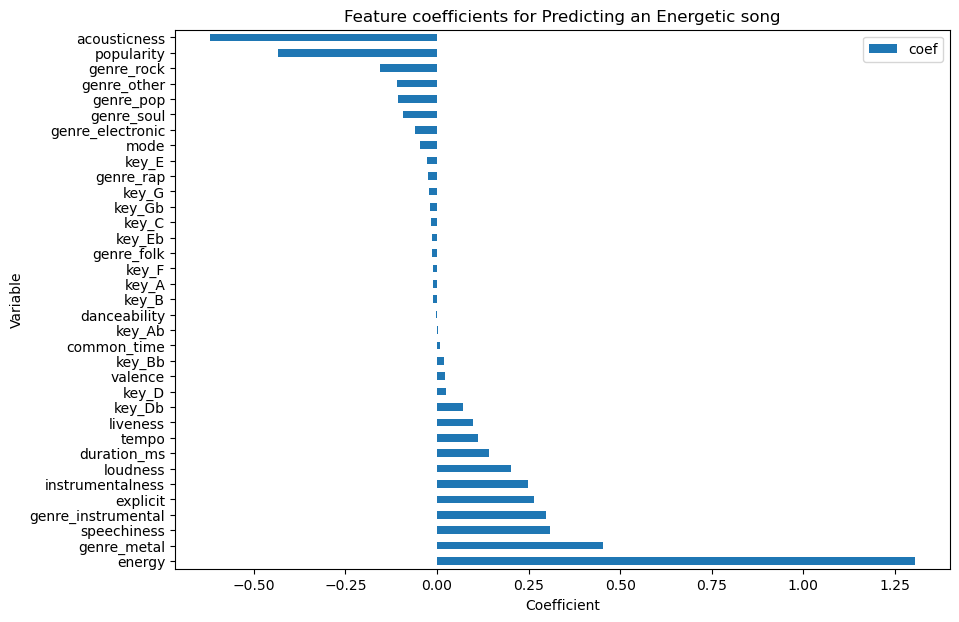

In [209]:
pipe.fit(X_train_ec, y_train_ec)
ec_train_score = pipe.score(X_train_ec, y_train_ec)
ec_test_score = pipe.score(X_test_ec, y_test_ec)

logreg_model = pipe.named_steps['model']  # retrieve the logistic regression model from the pipeline
features_df = pd.DataFrame()
features_df['coef'] = logreg_model.coef_[0]
features_df['features'] = X_train_hs.columns
coefficients = features_df.sort_values(by='coef', ascending=False).reset_index(drop=True)

# plot the HS coefficients
plt.figure(figsize=(10, 7))
coefficients.plot(kind='barh', x='features', ax=plt.gca())
plt.title('Feature coefficients for Predicting an Energetic song')
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.show()


To confirm what the coefficients are predicting, we can check the classes of the model.  The first element in the list represents the negative class, the second element represents the positive class.

In [210]:
logreg_model = pipe.named_steps['model']
print(logreg_model.classes_)

['chill' 'energetic']


We can see from the model classes that 'energetic' is the positive class.  Therefore a positive coefficient represents a higher probability of that song belonging to the energetic class.

Interpreting the results based on this, we see that 'energy' is the strongest predictor of an energetic song, where a unit increase in energy results in a exp(1.25) increase in the probability of the song belonging to the energetic class.  The other strong predictors (positive or negative) are acousticness, genre_metal and popularity.

There are a few features that don't contribute much to the odds change of the class, for example most of the 'key_' features.  The optimised model could therefore benefit from some feature reduction.

Append the prediction accuracies to the results dataframe.

In [211]:
new_rowlist = ["baseline_preproc", 'EC', ec_train_score, ec_test_score]
results_df.loc[len(results_df)] = new_rowlist
results_df

,Model,Dataset,train_score,test_score
0,baseline_raw,EC,0.761717,0.761137
1,baseline_raw,HS,0.612460,0.615771
2,baseline_preproc,EC,0.820935,0.802937


The accuracy on the energy/chill (EC) dataset has improved on both the train and the test set.  Therefore our preprocessing and feature engineering can be considered worthwhile.

Now let's fit and score the pipeline on the happy/sad (HS) dataset.

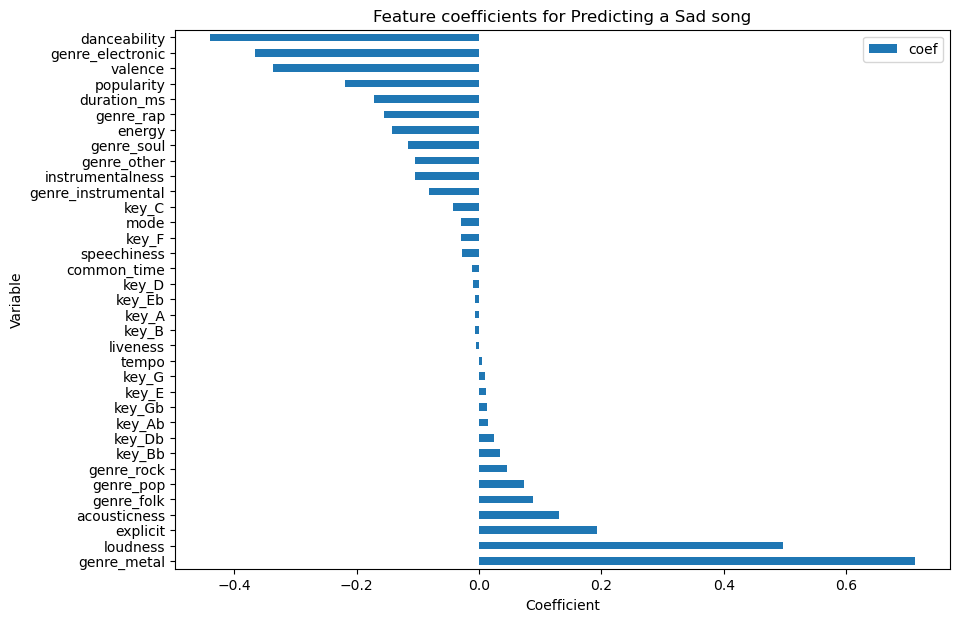

In [212]:
pipe.fit(X_train_hs, y_train_hs)
hs_train_score = pipe.score(X_train_hs, y_train_hs)
hs_test_score = pipe.score(X_test_hs, y_test_hs)

logreg_model = pipe.named_steps['model']  # retrieve the logistic regression model from the pipeline
features_df = pd.DataFrame()
features_df['coef'] = logreg_model.coef_[0]
features_df['features'] = X_train_hs.columns
coefficients = features_df.sort_values(by='coef', ascending=False).reset_index(drop=True)

# plot the HS coefficients
plt.figure(figsize=(10, 7))
coefficients.plot(kind='barh', x='features', ax=plt.gca())
plt.title('Feature coefficients for Predicting a Sad song')
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.show()

Check the prediction classes

In [213]:
logreg_model = pipe.named_steps['model']
print(logreg_model.classes_)

['happy' 'sad']


The coefficients tell us that 'genre_metal' is the best predictor of a song being sad, followed by 'loudness','genre_electronic', and 'valence'.

We also see the same potential for feature selection that we saw on the EC data.

Append accuracies to the results dataframe.

In [214]:
new_rowlist = ["baseline_preproc", 'HS', hs_train_score, hs_test_score]
results_df.loc[len(results_df)] = new_rowlist

In [215]:
results_df

,Model,Dataset,train_score,test_score
0,baseline_raw,EC,0.761717,0.761137
1,baseline_raw,HS,0.612460,0.615771
2,baseline_preproc,EC,0.820935,0.802937
3,baseline_preproc,HS,0.689941,0.675709


The prediction accuracy has also improved on both the train and the test set for the HS dataset.  Our pre-processing and feature engineering was beneficial.

### Optimising the Models

#### Energetic vs Chilled model

Now that we have a good baseline from which to improve, let's look at optimising the hyperparameters, starting with the energetic/chilled dataset.

In [216]:
X_train_ec.shape

(46391, 35)

We have 35 features and we saw from the baseline model that many of them are not strong predictors.  We want to retain interpretability so that we can apply the same model to both datasets, so let's test KBest.

We also want to narrow down a regularisation C-value for the model to generalise and perform well on the test set and new data.

Let's run a grid search with a wide range of K values and C values to narrow down the best value, before optimising other parameters.  We will also scan across MinMax, StandardScaler and RobustScaler for different normalisation options, compare the default solver of 'lbfgs' with 'liblinear' and compare 'l1' penalty with 'l2'.

For hyperparameter optimisation we will employ 5 fold cross-validation.

In [217]:
# estimators = [('normalise', StandardScaler()),
#               ('reduce_dim', SelectKBest()),
#               ('model', LogisticRegression())]

# pipe = Pipeline(estimators)

# c_list = [0.0001, 0.001, 0.01, 0.1, 1]
# kbest = [15, 20, 25, 30, 33]

# param_grid = [
#             {'normalise': [StandardScaler(), MinMaxScaler(), RobustScaler()],
#              'reduce_dim': [SelectKBest()],
#              'reduce_dim__score_func': [f_classif, chi2],
#              'reduce_dim__k': kbest,
#              'model': [LogisticRegression(n_jobs=-1)],
#              'model__solver': ['lbfgs', 'liblinear'],
#              'model__penalty': ['l2', 'l1'],
#              'model__C': c_list}]

# grid = GridSearchCV(pipe, param_grid, cv=5)
# fittedgrid = grid.fit(X_train_ec, y_train_ec)

In [218]:
# joblib.dump(fittedgrid, "./data/pickles/EC_model_gs2.pkl")

In [219]:
fittedgrid = joblib.load("./data/pickles/EC_model_gs2.pkl")

In [220]:
bestparams = fittedgrid.best_params_
bestparams['score (%)'] = round(fittedgrid.best_score_*100, 3)
bestparams['classification'] = fittedgrid.classes_[1]
params_df = pd.DataFrame(data=bestparams, index=[0])
params_df

,model,model__C,model__penalty,model__solver,normalise,reduce_dim,reduce_dim__k,reduce_dim__score_func,score (%),classification
0,"LogisticRegression(C=0.01, n_jobs=-1)",0.01,l2,lbfgs,StandardScaler(),SelectKBest(k=33),33,<function f_classif at 0x0000019275033370>,82.072,energetic


The first gridsearch has taken the cross-validated accuracy to 82.072%, higher than the baseline.

The optimum KBest for this run was 33, meaning that our prediction accuracy is best with the most features possible.  This is not surprising in itself, as we would expect very minor improvements in prediction accuracy with the inclusion of additional features.  However, we may still want to see how the model performs with fewer features for the sake of interpretability.

Let's run another grid search with a lower range of k-values.

In [221]:
# estimators = [('normalise', StandardScaler()),
#               ('reduce_dim', SelectKBest()),
#               ('model', LogisticRegression())]

# pipe = Pipeline(estimators)

# c_list = [0.0001, 0.001, 0.01, 0.1, 1]
# kbest = [3, 5, 8, 11, 14, 17, 21]

# param_grid = [
#             {'normalise': [StandardScaler(), MinMaxScaler()],
#              'reduce_dim': [SelectKBest()],
#              'reduce_dim__score_func': [f_classif],
#              'reduce_dim__k': kbest,
#              'model': [LogisticRegression(n_jobs=-1)],
#              'model__solver': ['lbfgs', 'liblinear'],
#              'model__penalty': ['l2', 'l1'],
#              'model__C': c_list}]

# grid = GridSearchCV(pipe, param_grid, cv=5)
# fittedgrid = grid.fit(X_train_ec, y_train_ec)

In [222]:
# joblib.dump(fittedgrid, "./data/pickles/EC_model_gs3.pkl")

In [223]:
fittedgrid = joblib.load("./data/pickles/EC_model_gs3.pkl")

In [224]:
bestparams = fittedgrid.best_params_
bestparams['score (%)'] = round(fittedgrid.best_score_*100, 3)
bestparams['classification'] = fittedgrid.classes_[1]
params_df2 = pd.DataFrame(data=bestparams, index=[0])
params_df = pd.concat([params_df, params_df2], axis=0)
params_df

,model,model__C,model__penalty,model__solver,normalise,reduce_dim,reduce_dim__k,reduce_dim__score_func,score (%),classification
0,"LogisticRegression(C=0.01, n_jobs=-1)",0.010,l2,lbfgs,StandardScaler(),SelectKBest(k=33),33,<function f_classif at 0x0000019275033370>,82.072,energetic
0,"LogisticRegression(C=0.001, n_jobs=-1)",0.001,l2,lbfgs,StandardScaler(),SelectKBest(k=17),17,<function f_classif at 0x0000019275033370>,82.009,energetic


In modelling with the smaller number of features, we have dropped from 33 to 17 features but only lost 0.062% prediction accuracy.  With a smaller number of features we have a model that is more interpretable and is likely to generalise better to new data.

Let's run a cross validated check of a range of K features using cv_results.  Using cv results we can also check the standard deviation of our cross validation to get a sense of the bias/variance.

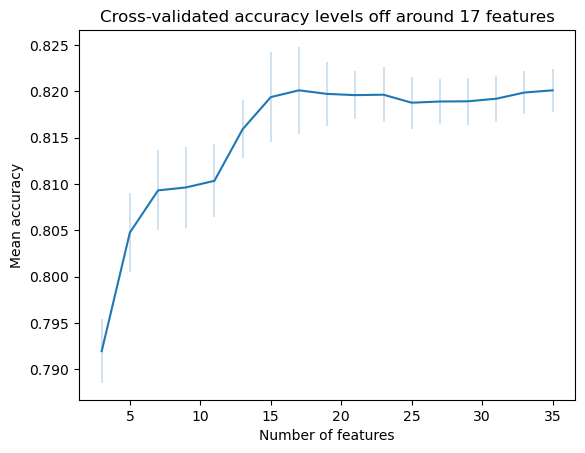

In [225]:
# Define the pipeline
estimators = [('normalise', StandardScaler()),
              ('reduce_dim', SelectKBest()),
              ('model', LogisticRegression(solver='lbfgs',penalty = 'l2', C = 0.001))]

pipe = Pipeline(estimators)

# Define the range of k values to test
k_values = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35]

# Define the parameter grid for GridSearchCV
param_grid = {'reduce_dim__k': k_values}

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5)

# Fit the grid search object
grid_search.fit(X_train_ec, y_train_ec)

# Get the mean cross-validation scores and standard deviations for each k value
mean_scores = grid_search.cv_results_['mean_test_score']
std_scores = grid_search.cv_results_['std_test_score']

# Save the mean scores and standard deviations to lists
mean_scores_list = []
std_scores_list = []

for mean, std in zip(mean_scores, std_scores):
    mean_scores_list.append(mean)
    std_scores_list.append(std)

# Plot the mean cross-validation scores with error bars
plt.errorbar(k_values, mean_scores_list, yerr=std_scores_list, elinewidth=0.3)
plt.title('Cross-validated accuracy levels off around 17 features')
plt.xlabel('Number of features')
plt.ylabel('Mean accuracy')
plt.show()

The cross-validation plot shows the accuracy score increase and peak at k= 17, but this is also where the standard deviation is greatest, suggesting the model performs differently on different strata of the data. As the number of features increases from here the standard deviation drops and the accuracy score stays fairly constant.

This would lead us to conclude that for this C value (0.001), a sensible value for K is around 19 or 21, as we have a high accuracy score and a smaller standard deviation.

Run another grid search narrowing down the K-value to our chosen range, and having a narrower range of C around the previous best.  We will leave the normalisation, solver and penalty set to the values that have been selected so far.

In [226]:
# estimators = [('normalise', StandardScaler()),
#               ('reduce_dim', SelectKBest()),
#               ('model', LogisticRegression())]

# pipe = Pipeline(estimators)

# c_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
# kbest = [15, 16, 17, 18, 19, 20, 21]

# param_grid = [
#             {'normalise': [StandardScaler()],
#              'reduce_dim': [SelectKBest()],
#              'reduce_dim__score_func': [f_classif],
#              'reduce_dim__k': kbest,
#              'model': [LogisticRegression(n_jobs=-1)],
#              'model__solver': ['lbfgs'],
#              'model__penalty': ['l2'],
#              'model__C': c_list}]

# grid = GridSearchCV(pipe, param_grid, cv=5)
# fittedgrid = grid.fit(X_train_ec, y_train_ec)

In [227]:
# joblib.dump(fittedgrid, "./data/pickles/EC_model_gs4.pkl")

In [228]:
fittedgrid = joblib.load("./data/pickles/EC_model_gs4.pkl")

In [229]:
bestparams = fittedgrid.best_params_
bestparams['score (%)'] = round(fittedgrid.best_score_*100, 3)
bestparams['classification'] = fittedgrid.classes_[1]
params_df2 = pd.DataFrame(data=bestparams, index=[0])
params_df = pd.concat([params_df, params_df2], axis=0)
params_df

,model,model__C,model__penalty,model__solver,normalise,reduce_dim,reduce_dim__k,reduce_dim__score_func,score (%),classification
0,"LogisticRegression(C=0.01, n_jobs=-1)",0.010,l2,lbfgs,StandardScaler(),SelectKBest(k=33),33,<function f_classif at 0x0000019275033370>,82.072,energetic
0,"LogisticRegression(C=0.001, n_jobs=-1)",0.001,l2,lbfgs,StandardScaler(),SelectKBest(k=17),17,<function f_classif at 0x0000019275033370>,82.009,energetic
0,"LogisticRegression(C=0.005, n_jobs=-1)",0.005,l2,lbfgs,StandardScaler(),SelectKBest(k=19),19,<function f_classif at 0x0000019275033370>,82.040,energetic


The peak accuracy score from the range of K-values we allowed is 82.04, an increase on the previous accuracy, and only 0.03% lower than including all features.  Let's use this value to narrow down on our optimum C regularisation.  We will allow K to fluctuate a little either side of 19 to zero in on the optimum accuracy.

In [230]:
# estimators = [('normalise', StandardScaler()),
#               ('reduce_dim', SelectKBest()),
#               ('model', LogisticRegression())]

# pipe = Pipeline(estimators)

# c_list = [0.0001, 0.0025, 0.005, 0.0075, 0.01]
# kbest = [18, 19, 20]

# param_grid = [
#             {'normalise': [StandardScaler()],
#              'reduce_dim': [SelectKBest()],
#              'reduce_dim__score_func': [f_classif],
#              'reduce_dim__k': kbest,
#              'model': [LogisticRegression(n_jobs=-1)],
#              'model__solver': ['lbfgs'],
#              'model__penalty': ['l2'],
#              'model__C': c_list}]

# grid = GridSearchCV(pipe, param_grid, cv=5)
# fittedgrid = grid.fit(X_train_ec, y_train_ec)

In [231]:
# joblib.dump(fittedgrid, "./data/pickles/EC_model_gs5.pkl")

In [232]:
fittedgrid = joblib.load("./data/pickles/EC_model_gs5.pkl")

In [233]:
bestparams = fittedgrid.best_params_
bestparams['score (%)'] = round(fittedgrid.best_score_*100, 3)
bestparams['classification'] = fittedgrid.classes_[1]
params_df2 = pd.DataFrame(data=bestparams, index=[0])
params_df = pd.concat([params_df, params_df2], axis=0)
params_df

,model,model__C,model__penalty,model__solver,normalise,reduce_dim,reduce_dim__k,reduce_dim__score_func,score (%),classification
0,"LogisticRegression(C=0.01, n_jobs=-1)",0.0100,l2,lbfgs,StandardScaler(),SelectKBest(k=33),33,<function f_classif at 0x0000019275033370>,82.072,energetic
0,"LogisticRegression(C=0.001, n_jobs=-1)",0.0010,l2,lbfgs,StandardScaler(),SelectKBest(k=17),17,<function f_classif at 0x0000019275033370>,82.009,energetic
0,"LogisticRegression(C=0.005, n_jobs=-1)",0.0050,l2,lbfgs,StandardScaler(),SelectKBest(k=19),19,<function f_classif at 0x0000019275033370>,82.040,energetic
0,"LogisticRegression(C=0.0025, n_jobs=-1)",0.0025,l2,lbfgs,StandardScaler(),SelectKBest(k=20),20,<function f_classif at 0x0000019275033370>,82.046,energetic


The accuracy has improved very slightly by going from 19 to 20 features and slightly adjusting the regularisation from 0.005 to 0.0025 (more regularised).  This is sensible as the model is raising the regularisation to avoid overfitting with the introduction of an additional feature.

Let's continue with these parameters, and finally optimise the solver and number of iterations, testing newton-cg, and sag as these support l2 penalty, and testing 10, 50, 100, 1000, 10000 iterations.

In [234]:
# estimators = [('normalise', StandardScaler()),
#               ('reduce_dim', SelectKBest()),
#               ('model', LogisticRegression())]

# pipe = Pipeline(estimators)

# c_list = [0.0025]
# kbest = [20]

# param_grid = [
#             {'normalise': [StandardScaler()],
#              'reduce_dim': [SelectKBest()],
#              'reduce_dim__score_func': [f_classif],
#              'reduce_dim__k': kbest,
#              'model': [LogisticRegression(n_jobs=-1)],
#              'model__max_iter': [3, 5, 10, 50, 100, 1000],
#              'model__solver': ['lbfgs', 'newton-cg', 'sag'],
#              'model__penalty': ['l2'],
#              'model__C': c_list}]

# grid = GridSearchCV(pipe, param_grid, cv=5)
# fittedgrid = grid.fit(X_train_ec, y_train_ec)

In [235]:
# joblib.dump(fittedgrid, "./data/pickles/EC_model_gs6.pkl")

In [236]:
fittedgrid = joblib.load("./data/pickles/EC_model_gs6.pkl")

In [237]:
bestparams = fittedgrid.best_params_
bestparams['score (%)'] = round(fittedgrid.best_score_*100, 3)
bestparams['classification'] = fittedgrid.classes_[1]
params_df2 = pd.DataFrame(data=bestparams, index=[0])
params_df = pd.concat([params_df, params_df2], axis=0)
params_df

,model,model__C,model__penalty,model__solver,normalise,reduce_dim,reduce_dim__k,reduce_dim__score_func,score (%),classification,model__max_iter
0,"LogisticRegression(C=0.01, n_jobs=-1)",0.0100,l2,lbfgs,StandardScaler(),SelectKBest(k=33),33,<function f_classif at 0x0000019275033370>,82.072,energetic,NaN
0,"LogisticRegression(C=0.001, n_jobs=-1)",0.0010,l2,lbfgs,StandardScaler(),SelectKBest(k=17),17,<function f_classif at 0x0000019275033370>,82.009,energetic,NaN
0,"LogisticRegression(C=0.005, n_jobs=-1)",0.0050,l2,lbfgs,StandardScaler(),SelectKBest(k=19),19,<function f_classif at 0x0000019275033370>,82.040,energetic,NaN
0,"LogisticRegression(C=0.0025, n_jobs=-1)",0.0025,l2,lbfgs,StandardScaler(),SelectKBest(k=20),20,<function f_classif at 0x0000019275033370>,82.046,energetic,NaN
0,"LogisticRegression(C=0.0025, max_iter=3, n_job...",0.0025,l2,sag,StandardScaler(),SelectKBest(k=20),20,<function f_classif at 0x0000019275033370>,82.091,energetic,3.0


The best accuracy score comes from a surprisingly low number of iterations of 3. A model converging quickly on the result could be a sign that there is good separation between the classes of energetic and chilled, and the model doesn't need many iterations to find a decision boundary.  Let's confirm the model performance on a plot to visualise what is happening

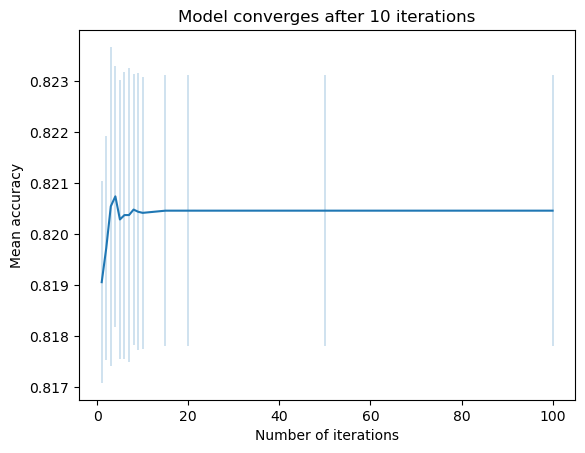

In [238]:
# Define the pipeline
estimators = [('normalise', StandardScaler()),
              ('reduce_dim', SelectKBest(k=20, score_func=f_classif)),
              ('model', LogisticRegression(solver='sag',penalty = 'l2', C = 0.0025))]

pipe = Pipeline(estimators)

# Define the range of iterations to scan
iters = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 50, 100]

# Define the parameter grid for GridSearchCV
param_grid = {'model__max_iter': iters}

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5)

# Fit the grid search object
grid_search.fit(X_train_ec, y_train_ec)

# Get the mean cross-validation scores and standard deviations for each k value
mean_scores = grid_search.cv_results_['mean_test_score']
std_scores = grid_search.cv_results_['std_test_score']

# Save the mean scores and standard deviations to lists
mean_scores_list = []
std_scores_list = []

for mean, std in zip(mean_scores, std_scores):
    mean_scores_list.append(mean)
    std_scores_list.append(std)

# Plot the mean cross-validation scores with error bars
plt.errorbar(iters, mean_scores_list, yerr=std_scores_list, elinewidth=0.3)
plt.title('Model converges after 10 iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Mean accuracy')
plt.show()



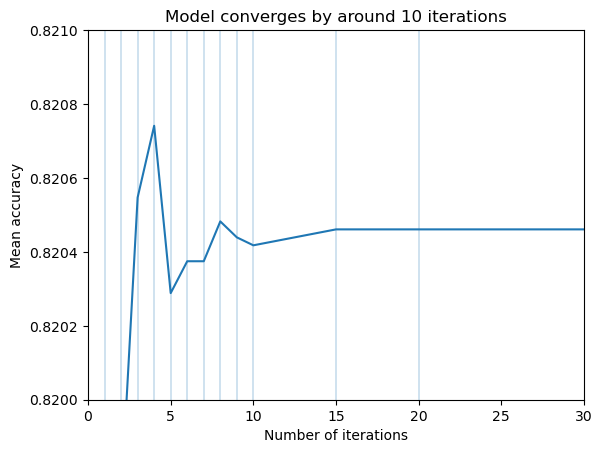

In [239]:
# Plot the mean cross-validation scores with error bars
plt.errorbar(iters, mean_scores_list, yerr=std_scores_list, elinewidth=0.3)
plt.title('Model converges by around 10 iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Mean accuracy')
plt.ylim(0.820, 0.821)
plt.xlim(0,30)
plt.show()

Judging by the plot, we can see that the model accuracy score peaks at very low numbers of iterations, but the variance from each iteration to the next suggests that the model is underfitted, and may be too simple to fit the training model well for all validation folds.  Let's run one more grid search for low numbers of iterations, but with a minimum of 10.

In [240]:
# estimators = [('normalise', StandardScaler()),
#               ('reduce_dim', SelectKBest()),
#               ('model', LogisticRegression())]

# pipe = Pipeline(estimators)

# c_list = [0.0025]
# kbest = [20]

# param_grid = [
#             {'normalise': [StandardScaler()],
#              'reduce_dim': [SelectKBest()],
#              'reduce_dim__score_func': [f_classif],
#              'reduce_dim__k': kbest,
#              'model': [LogisticRegression(n_jobs=-1)],
#              'model__max_iter': [10, 15, 20, 25, 30, 40, 50],
#              'model__solver': ['lbfgs', 'newton-cg', 'sag'],
#              'model__penalty': ['l2'],
#              'model__C': c_list}]

# grid = GridSearchCV(pipe, param_grid, cv=5)
# fittedgrid = grid.fit(X_train_ec, y_train_ec)

In [241]:
# joblib.dump(fittedgrid, "./data/pickles/EC_model_gs7.pkl")

In [242]:
fittedgrid = joblib.load("./data/pickles/EC_model_gs7.pkl")

In [243]:
bestparams = fittedgrid.best_params_
bestparams['score (%)'] = round(fittedgrid.best_score_*100, 3)
bestparams['classification'] = fittedgrid.classes_[1]
params_df2 = pd.DataFrame(data=bestparams, index=[0])
params_df = pd.concat([params_df, params_df2], axis=0)
params_df

,model,model__C,model__penalty,model__solver,normalise,reduce_dim,reduce_dim__k,reduce_dim__score_func,score (%),classification,model__max_iter
0,"LogisticRegression(C=0.01, n_jobs=-1)",0.0100,l2,lbfgs,StandardScaler(),SelectKBest(k=33),33,<function f_classif at 0x0000019275033370>,82.072,energetic,NaN
0,"LogisticRegression(C=0.001, n_jobs=-1)",0.0010,l2,lbfgs,StandardScaler(),SelectKBest(k=17),17,<function f_classif at 0x0000019275033370>,82.009,energetic,NaN
0,"LogisticRegression(C=0.005, n_jobs=-1)",0.0050,l2,lbfgs,StandardScaler(),SelectKBest(k=19),19,<function f_classif at 0x0000019275033370>,82.040,energetic,NaN
0,"LogisticRegression(C=0.0025, n_jobs=-1)",0.0025,l2,lbfgs,StandardScaler(),SelectKBest(k=20),20,<function f_classif at 0x0000019275033370>,82.046,energetic,NaN
0,"LogisticRegression(C=0.0025, max_iter=3, n_job...",0.0025,l2,sag,StandardScaler(),SelectKBest(k=20),20,<function f_classif at 0x0000019275033370>,82.091,energetic,3.0
0,"LogisticRegression(C=0.0025, max_iter=10, n_jo...",0.0025,l2,lbfgs,StandardScaler(),SelectKBest(k=20),20,<function f_classif at 0x0000019275033370>,82.050,energetic,10.0


As expected from the above plot, the best accuracy is at 10 iterations, immediately after the model has converged.  These will be our selected model parameters.  By optimising the hyperparameters we have achieved an improved prediction accuracy compared with the baseline and similar to the initial tests that included 33 features.

Now let's fit our chosen model parameters to the train set and score on the train and test sets.

In [244]:
#instantiate pipeline

estimators = [('normalise', StandardScaler()),
              ('reduce_dim', SelectKBest(k=20, score_func=f_classif)),
              ('model', LogisticRegression(solver='lbfgs',penalty = 'l2', C = 0.0025, max_iter=10))]

pipe = Pipeline(estimators)

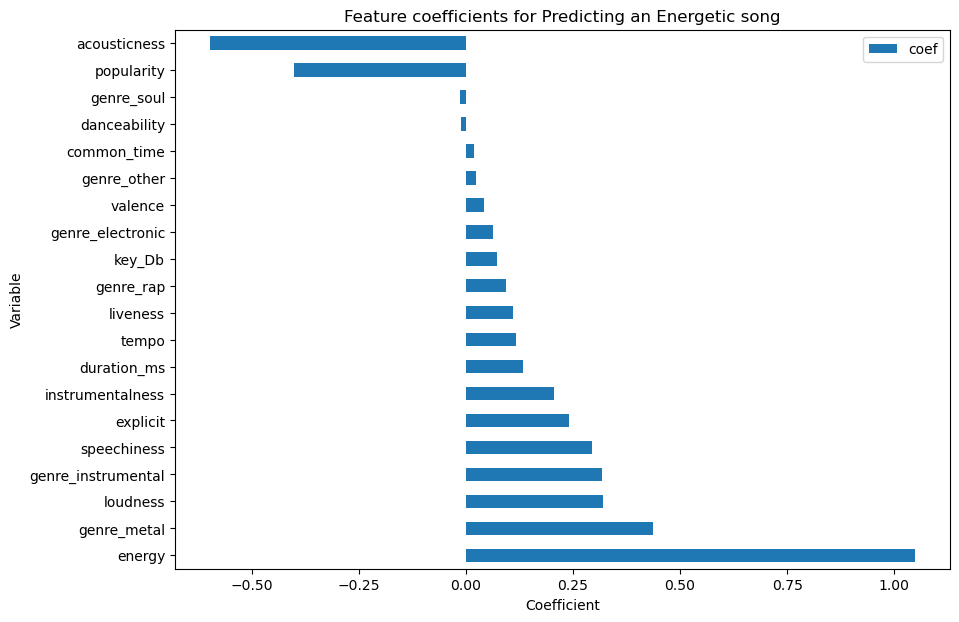

,Model,Dataset,train_score,test_score
0,baseline_raw,EC,0.761717,0.761137
1,baseline_raw,HS,0.612460,0.615771
2,baseline_preproc,EC,0.820935,0.802937
3,baseline_preproc,HS,0.689941,0.675709
4,optimised,EC,0.820676,0.801369


In [245]:
# fit and score model
pipe.fit(X_train_ec, y_train_ec)
ec_train_score = pipe.score(X_train_ec, y_train_ec)
ec_test_score = pipe.score(X_test_ec, y_test_ec)

# put coefficient results in a dataframe for plotting

logreg_model = pipe.named_steps['model'] # retrieve the logistic regression model from the pipeline
skb = pipe.named_steps['reduce_dim'] # retrieve the selectKBest from the pipeline
ec_features_df = pd.DataFrame()
ec_features_df['features'] = X_train_ec.columns
ec_features_df['selected'] = skb.get_support()
ec_features_df = ec_features_df.loc[ec_features_df['selected'] == True]
ec_features_df['coef'] = logreg_model.coef_[0]

ec_coefficients = ec_features_df.sort_values(by='coef', ascending=False).reset_index(drop=True)

# plot the coefficients
plt.figure(figsize=(10, 7))
ec_coefficients.plot(kind='barh', x='features', ax=plt.gca())
plt.title('Feature coefficients for Predicting an Energetic song')
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.show()

# add score to results dataframe
new_rowlist = ["optimised", 'EC', ec_train_score, ec_test_score]
results_df.loc[len(results_df)] = new_rowlist
results_df

The score on the test set is almost the same as the score on the baseline.  This can be considered a successful result as we have dropped 15 features in the process.

#### Happy vs Sad Model

In [246]:
# estimators = [('normalise', StandardScaler()),
#               ('reduce_dim', SelectKBest()),
#               ('model', LogisticRegression())]

# pipe = Pipeline(estimators)

# c_list = [0.0001, 0.001, 0.01, 0.1, 1]
# kbest = [5, 10, 15, 20, 25, 30, 33]

# param_grid = [
#             {'normalise': [StandardScaler(), MinMaxScaler(), RobustScaler()],
#              'reduce_dim': [SelectKBest()],
#              'reduce_dim__score_func': [f_classif, chi2],
#              'reduce_dim__k': kbest,
#              'model': [LogisticRegression(n_jobs=-1)],
#              'model__solver': ['lbfgs', 'liblinear'],
#              'model__penalty': ['l2', 'l1'],
#              'model__C': c_list}]

# grid = GridSearchCV(pipe, param_grid, cv=5)
# fittedgrid = grid.fit(X_train_hs, y_train_hs)

In [247]:
# joblib.dump(fittedgrid, "./data/pickles/HS_model_gs1.pkl")

In [248]:
fittedgrid = joblib.load("./data/pickles/HS_model_gs1.pkl")

In [249]:
bestparams = fittedgrid.best_params_
bestparams['score (%)'] = round(fittedgrid.best_score_*100, 3)
bestparams['classification'] = fittedgrid.classes_[1]
params_df2 = pd.DataFrame(data=bestparams, index=[0])
params_df = pd.concat([params_df, params_df2], axis=0)
params_df

,model,model__C,model__penalty,model__solver,normalise,reduce_dim,reduce_dim__k,reduce_dim__score_func,score (%),classification,model__max_iter
0,"LogisticRegression(C=0.01, n_jobs=-1)",0.0100,l2,lbfgs,StandardScaler(),SelectKBest(k=33),33,<function f_classif at 0x0000019275033370>,82.072,energetic,NaN
0,"LogisticRegression(C=0.001, n_jobs=-1)",0.0010,l2,lbfgs,StandardScaler(),SelectKBest(k=17),17,<function f_classif at 0x0000019275033370>,82.009,energetic,NaN
0,"LogisticRegression(C=0.005, n_jobs=-1)",0.0050,l2,lbfgs,StandardScaler(),SelectKBest(k=19),19,<function f_classif at 0x0000019275033370>,82.040,energetic,NaN
0,"LogisticRegression(C=0.0025, n_jobs=-1)",0.0025,l2,lbfgs,StandardScaler(),SelectKBest(k=20),20,<function f_classif at 0x0000019275033370>,82.046,energetic,NaN
0,"LogisticRegression(C=0.0025, max_iter=3, n_job...",0.0025,l2,sag,StandardScaler(),SelectKBest(k=20),20,<function f_classif at 0x0000019275033370>,82.091,energetic,3.0
0,"LogisticRegression(C=0.0025, max_iter=10, n_jo...",0.0025,l2,lbfgs,StandardScaler(),SelectKBest(k=20),20,<function f_classif at 0x0000019275033370>,82.050,energetic,10.0
0,"LogisticRegression(C=0.1, n_jobs=-1, solver='l...",0.1000,l2,liblinear,MinMaxScaler(),SelectKBest(k=30),30,<function f_classif at 0x0000019275033370>,68.994,sad,NaN


Here we have a good optimised baseline to work from.  Let's start by looking at the number of features plot to see at what number of features the accuracy levels off.

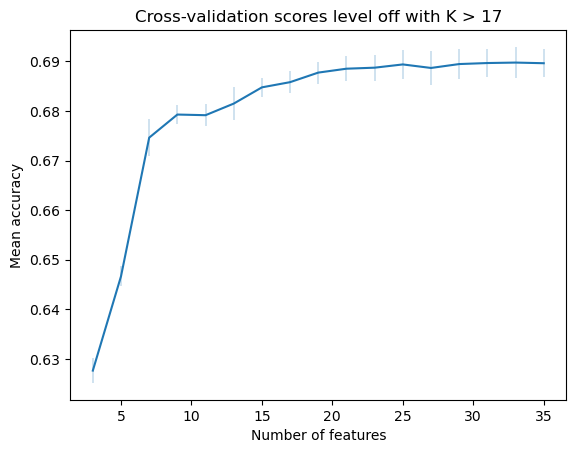

In [250]:
# Define the pipeline
estimators = [('normalise', MinMaxScaler()),
              ('reduce_dim', SelectKBest()),
              ('model', LogisticRegression(solver='liblinear',penalty = 'l2', C = 0.1))]

pipe = Pipeline(estimators)

# Define the range of k values to test
k_values = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35]

# Define the parameter grid for GridSearchCV
param_grid = {'reduce_dim__k': k_values}

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5)

# Fit the grid search object
grid_search.fit(X_train_hs, y_train_hs)

# Get the mean cross-validation scores and standard deviations for each k value
mean_scores = grid_search.cv_results_['mean_test_score']
std_scores = grid_search.cv_results_['std_test_score']

# Save the mean scores and standard deviations to lists
mean_scores_list = []
std_scores_list = []

for mean, std in zip(mean_scores, std_scores):
    mean_scores_list.append(mean)
    std_scores_list.append(std)

# Plot the mean cross-validation scores with error bars
plt.errorbar(k_values, mean_scores_list, yerr=std_scores_list, elinewidth=0.3)
plt.title('Cross-validation scores level off with K > 17')
plt.xlabel('Number of features')
plt.ylabel('Mean accuracy')
plt.show()

The accuracy levels off around 17 features and above, though the accuracy does appear to continue to rise with the inclusion of more features.  However, the difference in accuracy score is very small from including extra features, with an increase of less than 0.002% when increasing from 19 to 35.  This can be seen on the plot below with a zoomed in scale.

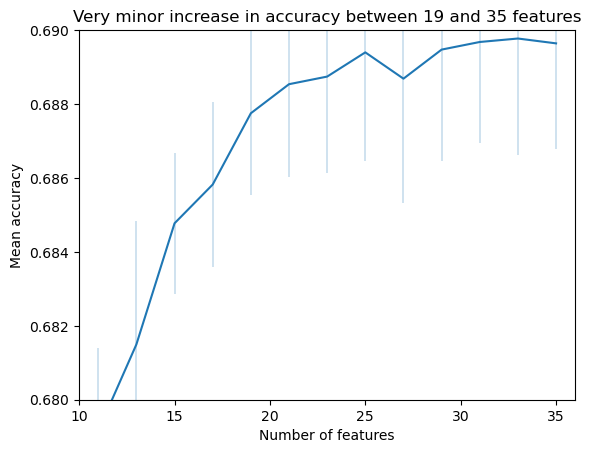

In [251]:
# Plot the mean cross-validation scores with error bars
plt.errorbar(k_values, mean_scores_list, yerr=std_scores_list, elinewidth=0.3)
plt.title('Very minor increase in accuracy between 19 and 35 features')
plt.xlabel('Number of features')
plt.ylabel('Mean accuracy')
plt.ylim(0.68, 0.69)
plt.xlim(10, 36)
plt.show()

For the purposes of our model being more interpretable and more likely to generalise to unseen data, let's limit Kbest to a range of 19-25 for subsequent grid searches.

In [252]:
# estimators = [('normalise', StandardScaler()),
#               ('reduce_dim', SelectKBest()),
#               ('model', LogisticRegression())]

# pipe = Pipeline(estimators)

# c_list = [0.001, 0.01, 0.1, 1]
# kbest = [19, 21, 23, 25]

# param_grid = [
#             {'normalise': [StandardScaler(), MinMaxScaler()],
#              'reduce_dim': [SelectKBest()],
#              'reduce_dim__score_func': [f_classif],
#              'reduce_dim__k': kbest,
#              'model': [LogisticRegression(n_jobs=-1)],
#              'model__solver': ['lbfgs', 'liblinear'],
#              'model__penalty': ['l2', 'l1'],
#              'model__C': c_list}]

# grid = GridSearchCV(pipe, param_grid, cv=5)
# fittedgrid = grid.fit(X_train_hs, y_train_hs)

In [253]:
# joblib.dump(fittedgrid, "./data/pickles/HS_model_gs2.pkl")

In [254]:
fittedgrid = joblib.load("./data/pickles/HS_model_gs2.pkl")

In [255]:
bestparams = fittedgrid.best_params_
bestparams['score (%)'] = round(fittedgrid.best_score_*100, 3)
bestparams['classification'] = fittedgrid.classes_[1]
params_df2 = pd.DataFrame(data=bestparams, index=[0])
params_df = pd.concat([params_df, params_df2], axis=0)
params_df

,model,model__C,model__penalty,model__solver,normalise,reduce_dim,reduce_dim__k,reduce_dim__score_func,score (%),classification,model__max_iter
0,"LogisticRegression(C=0.01, n_jobs=-1)",0.0100,l2,lbfgs,StandardScaler(),SelectKBest(k=33),33,<function f_classif at 0x0000019275033370>,82.072,energetic,NaN
0,"LogisticRegression(C=0.001, n_jobs=-1)",0.0010,l2,lbfgs,StandardScaler(),SelectKBest(k=17),17,<function f_classif at 0x0000019275033370>,82.009,energetic,NaN
0,"LogisticRegression(C=0.005, n_jobs=-1)",0.0050,l2,lbfgs,StandardScaler(),SelectKBest(k=19),19,<function f_classif at 0x0000019275033370>,82.040,energetic,NaN
0,"LogisticRegression(C=0.0025, n_jobs=-1)",0.0025,l2,lbfgs,StandardScaler(),SelectKBest(k=20),20,<function f_classif at 0x0000019275033370>,82.046,energetic,NaN
0,"LogisticRegression(C=0.0025, max_iter=3, n_job...",0.0025,l2,sag,StandardScaler(),SelectKBest(k=20),20,<function f_classif at 0x0000019275033370>,82.091,energetic,3.0
0,"LogisticRegression(C=0.0025, max_iter=10, n_jo...",0.0025,l2,lbfgs,StandardScaler(),SelectKBest(k=20),20,<function f_classif at 0x0000019275033370>,82.050,energetic,10.0
0,"LogisticRegression(C=0.1, n_jobs=-1, solver='l...",0.1000,l2,liblinear,MinMaxScaler(),SelectKBest(k=30),30,<function f_classif at 0x0000019275033370>,68.994,sad,NaN
0,"LogisticRegression(C=0.01, n_jobs=-1, penalty=...",0.0100,l1,liblinear,StandardScaler(),SelectKBest(k=25),25,<function f_classif at 0x0000019275033370>,68.981,sad,NaN


The accuracy score has reduced by only 0.013%, and the penalty has noticeably changed from l2 to l1, meaning that the model is giving the most important features more weight, and scaling the least important features to zero. The normalisation is set to standard scaler and the the solver is liblinear, let's continue with these parameters to narrow down a C value.

In [256]:
# estimators = [('normalise', StandardScaler()),
#               ('reduce_dim', SelectKBest()),
#               ('model', LogisticRegression())]

# pipe = Pipeline(estimators)

# c_list = [0.001, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.1]
# kbest = [23, 24, 25]

# param_grid = [
#             {'normalise': [StandardScaler()],
#              'reduce_dim': [SelectKBest()],
#              'reduce_dim__score_func': [f_classif],
#              'reduce_dim__k': kbest,
#              'model': [LogisticRegression(n_jobs=-1)],
#              'model__solver': ['liblinear'],
#              'model__penalty': ['l1'],
#              'model__C': c_list}]

# grid = GridSearchCV(pipe, param_grid, cv=5)
# fittedgrid = grid.fit(X_train_hs, y_train_hs)

In [257]:
# joblib.dump(fittedgrid, "./data/pickles/HS_model_gs3.pkl")

In [258]:
fittedgrid = joblib.load("./data/pickles/HS_model_gs3.pkl")

In [259]:
bestparams = fittedgrid.best_params_
bestparams['score (%)'] = round(fittedgrid.best_score_*100, 3)
bestparams['classification'] = fittedgrid.classes_[1]
params_df2 = pd.DataFrame(data=bestparams, index=[0])
params_df = pd.concat([params_df, params_df2], axis=0)
params_df

,model,model__C,model__penalty,model__solver,normalise,reduce_dim,reduce_dim__k,reduce_dim__score_func,score (%),classification,model__max_iter
0,"LogisticRegression(C=0.01, n_jobs=-1)",0.0100,l2,lbfgs,StandardScaler(),SelectKBest(k=33),33,<function f_classif at 0x0000019275033370>,82.072,energetic,NaN
0,"LogisticRegression(C=0.001, n_jobs=-1)",0.0010,l2,lbfgs,StandardScaler(),SelectKBest(k=17),17,<function f_classif at 0x0000019275033370>,82.009,energetic,NaN
0,"LogisticRegression(C=0.005, n_jobs=-1)",0.0050,l2,lbfgs,StandardScaler(),SelectKBest(k=19),19,<function f_classif at 0x0000019275033370>,82.040,energetic,NaN
0,"LogisticRegression(C=0.0025, n_jobs=-1)",0.0025,l2,lbfgs,StandardScaler(),SelectKBest(k=20),20,<function f_classif at 0x0000019275033370>,82.046,energetic,NaN
0,"LogisticRegression(C=0.0025, max_iter=3, n_job...",0.0025,l2,sag,StandardScaler(),SelectKBest(k=20),20,<function f_classif at 0x0000019275033370>,82.091,energetic,3.0
0,"LogisticRegression(C=0.0025, max_iter=10, n_jo...",0.0025,l2,lbfgs,StandardScaler(),SelectKBest(k=20),20,<function f_classif at 0x0000019275033370>,82.050,energetic,10.0
0,"LogisticRegression(C=0.1, n_jobs=-1, solver='l...",0.1000,l2,liblinear,MinMaxScaler(),SelectKBest(k=30),30,<function f_classif at 0x0000019275033370>,68.994,sad,NaN
0,"LogisticRegression(C=0.01, n_jobs=-1, penalty=...",0.0100,l1,liblinear,StandardScaler(),SelectKBest(k=25),25,<function f_classif at 0x0000019275033370>,68.981,sad,NaN
0,"LogisticRegression(C=0.01, n_jobs=-1, penalty=...",0.0100,l1,liblinear,StandardScaler(),SelectKBest(k=24),24,<function f_classif at 0x0000019275033370>,68.990,sad,NaN


A wider choice of C parameters ends up with the same best C, but including 24 features as an option brings the score up a tiny amount.  Let's carry these model parameters through to optimising the number of iterations. 

It's useful to plot the convergence of the model with increasing iterations, so let's plot this as we did previously for energy/chilled

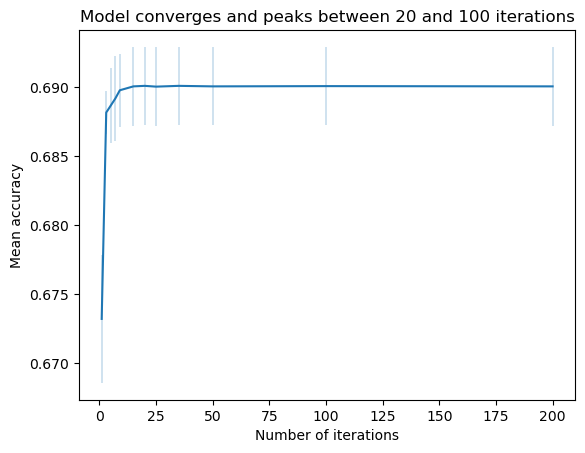

In [260]:
# Define the pipeline
estimators = [('normalise', StandardScaler()),
              ('reduce_dim', SelectKBest(k=24, score_func=f_classif)),
              ('model', LogisticRegression(solver='liblinear',penalty = 'l1', C = 0.01))]

pipe = Pipeline(estimators)

# Define the range of iterations to scan
iters = [1, 3, 5, 7, 9, 15, 20, 25, 35, 50, 100, 200]

# Define the parameter grid for GridSearchCV
param_grid = {'model__max_iter': iters}

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5)

# Fit the grid search object
grid_search.fit(X_train_hs, y_train_hs)

# Get the mean cross-validation scores and standard deviations for each k value
mean_scores = grid_search.cv_results_['mean_test_score']
std_scores = grid_search.cv_results_['std_test_score']

# Save the mean scores and standard deviations to lists
mean_scores_list = []
std_scores_list = []

for mean, std in zip(mean_scores, std_scores):
    mean_scores_list.append(mean)
    std_scores_list.append(std)

# Plot the mean cross-validation scores with error bars
plt.errorbar(iters, mean_scores_list, yerr=std_scores_list, elinewidth=0.3)
plt.title('Model converges and peaks between 20 and 100 iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Mean accuracy')
plt.show()

Zooming in on the y-axis

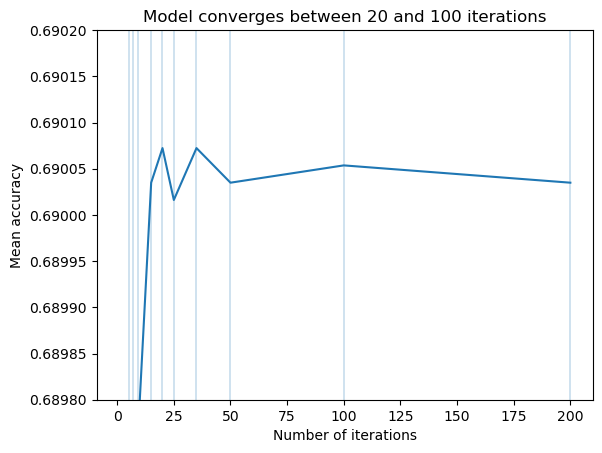

In [261]:
# Plot the mean cross-validation scores with error bars
plt.errorbar(iters, mean_scores_list, yerr=std_scores_list, elinewidth=0.3)
plt.title('Model converges between 20 and 100 iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Mean accuracy')
plt.ylim(0.6898, 0.6902)
plt.show()

The model converges on a solution between 20 and 100 iterations, and past this point the accuracy flatlines and no improvement is to be had from further iterations.

Let's confirm with a grid search

In [262]:
# estimators = [('normalise', StandardScaler()),
#               ('reduce_dim', SelectKBest()),
#               ('model', LogisticRegression())]

# pipe = Pipeline(estimators)

# c_list = [0.01]
# kbest = [24]

# param_grid = [
#             {'normalise': [StandardScaler()],
#              'reduce_dim': [SelectKBest()],
#              'reduce_dim__score_func': [f_classif],
#              'reduce_dim__k': kbest,
#              'model': [LogisticRegression(n_jobs=-1)],
#              'model__solver': ['liblinear'],
#              'model__penalty': ['l1'],
#              'model__max_iter': [5, 10, 20, 30, 50, 75, 100, 200, 300, 500, 750, 1000, 5000],
#              'model__C': c_list}]

# grid = GridSearchCV(pipe, param_grid, cv=5)
# fittedgrid = grid.fit(X_train_hs, y_train_hs)

In [263]:
# joblib.dump(fittedgrid, "./data/pickles/HS_model_gs4.pkl")

In [264]:
fittedgrid = joblib.load("./data/pickles/HS_model_gs4.pkl")

In [265]:
bestparams = fittedgrid.best_params_
bestparams['score (%)'] = round(fittedgrid.best_score_*100, 3)
bestparams['classification'] = fittedgrid.classes_[1]
params_df2 = pd.DataFrame(data=bestparams, index=[0])
params_df = pd.concat([params_df, params_df2], axis=0)
params_df

,model,model__C,model__penalty,model__solver,normalise,reduce_dim,reduce_dim__k,reduce_dim__score_func,score (%),classification,model__max_iter
0,"LogisticRegression(C=0.01, n_jobs=-1)",0.0100,l2,lbfgs,StandardScaler(),SelectKBest(k=33),33,<function f_classif at 0x0000019275033370>,82.072,energetic,NaN
0,"LogisticRegression(C=0.001, n_jobs=-1)",0.0010,l2,lbfgs,StandardScaler(),SelectKBest(k=17),17,<function f_classif at 0x0000019275033370>,82.009,energetic,NaN
0,"LogisticRegression(C=0.005, n_jobs=-1)",0.0050,l2,lbfgs,StandardScaler(),SelectKBest(k=19),19,<function f_classif at 0x0000019275033370>,82.040,energetic,NaN
0,"LogisticRegression(C=0.0025, n_jobs=-1)",0.0025,l2,lbfgs,StandardScaler(),SelectKBest(k=20),20,<function f_classif at 0x0000019275033370>,82.046,energetic,NaN
0,"LogisticRegression(C=0.0025, max_iter=3, n_job...",0.0025,l2,sag,StandardScaler(),SelectKBest(k=20),20,<function f_classif at 0x0000019275033370>,82.091,energetic,3.0
0,"LogisticRegression(C=0.0025, max_iter=10, n_jo...",0.0025,l2,lbfgs,StandardScaler(),SelectKBest(k=20),20,<function f_classif at 0x0000019275033370>,82.050,energetic,10.0
0,"LogisticRegression(C=0.1, n_jobs=-1, solver='l...",0.1000,l2,liblinear,MinMaxScaler(),SelectKBest(k=30),30,<function f_classif at 0x0000019275033370>,68.994,sad,NaN
0,"LogisticRegression(C=0.01, n_jobs=-1, penalty=...",0.0100,l1,liblinear,StandardScaler(),SelectKBest(k=25),25,<function f_classif at 0x0000019275033370>,68.981,sad,NaN
0,"LogisticRegression(C=0.01, n_jobs=-1, penalty=...",0.0100,l1,liblinear,StandardScaler(),SelectKBest(k=24),24,<function f_classif at 0x0000019275033370>,68.990,sad,NaN
0,"LogisticRegression(C=0.01, max_iter=75, n_jobs...",0.0100,l1,liblinear,StandardScaler(),SelectKBest(k=24),24,<function f_classif at 0x0000019275033370>,68.990,sad,75.0


As expected from the plots above, the best model accuracy is with a max_iter of 75.  These are our optimised hyperparameters.

Use these to fit to the train set and score on the test set.

In [266]:
#instantiate pipeline

estimators = [('normalise', StandardScaler()),
              ('reduce_dim', SelectKBest(k=24, score_func=f_classif)),
              ('model', LogisticRegression(solver='liblinear',penalty = 'l1', C = 0.01, max_iter=75))]

pipe = Pipeline(estimators)

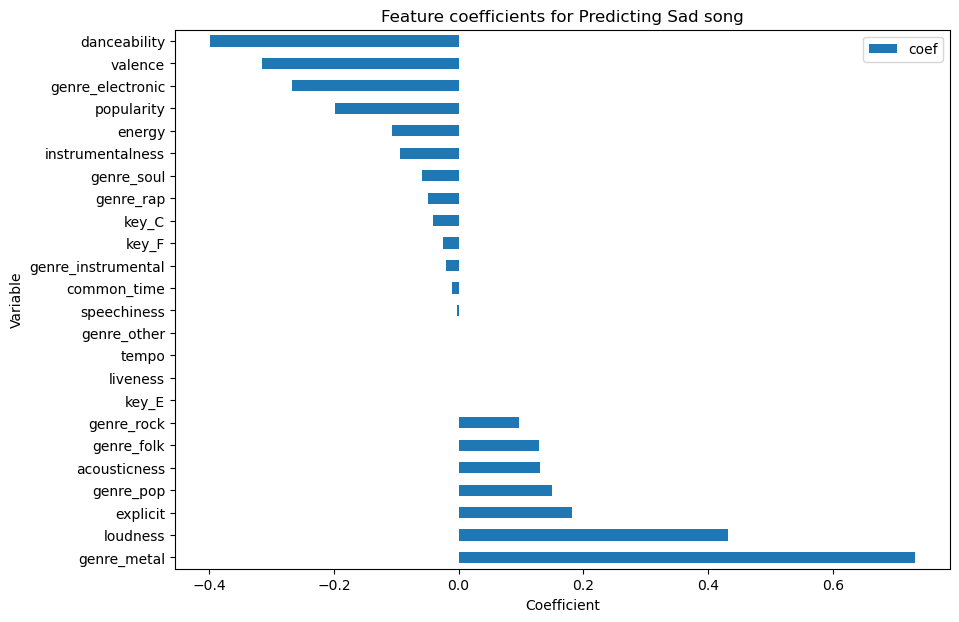

,Model,Dataset,train_score,test_score
0,baseline_raw,EC,0.761717,0.761137
1,baseline_raw,HS,0.612460,0.615771
2,baseline_preproc,EC,0.820935,0.802937
3,baseline_preproc,HS,0.689941,0.675709
4,optimised,EC,0.820676,0.801369
5,optimised,HS,0.690409,0.674285


In [267]:
# fit and score model
pipe.fit(X_train_hs, y_train_hs)
hs_train_score = pipe.score(X_train_hs, y_train_hs)
hs_test_score = pipe.score(X_test_hs, y_test_hs)

# put coefficient results in a dataframe for plotting

logreg_model = pipe.named_steps['model'] # retrieve the logistic regression model from the pipeline
skb = pipe.named_steps['reduce_dim'] # retrieve the selectKBest from the pipeline
hs_features_df = pd.DataFrame()
hs_features_df['features'] = X_train_hs.columns
hs_features_df['selected'] = skb.get_support()
hs_features_df = hs_features_df.loc[hs_features_df['selected'] == True]
hs_features_df['coef'] = logreg_model.coef_[0]

hs_coefficients = hs_features_df.sort_values(by='coef', ascending=False).reset_index(drop=True)

# plot the coefficients
plt.figure(figsize=(10, 7))
hs_coefficients.plot(kind='barh', x='features', ax=plt.gca())
plt.title('Feature coefficients for Predicting Sad song')
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.show()

# add score to results dataframe
new_rowlist = ["optimised", 'HS', hs_train_score, hs_test_score]
results_df.loc[len(results_df)] = new_rowlist
results_df

The optimised model scores show that we have retained a similar level of accuracy to the preprocessed baseline, whilst dropping 11 features.

### Combining the models

In order to give each song a happy score and an energy score, we will need to apply the 'HS' model to the 'EC' songs and apply the 'EC' model to the 'HS' songs.  

To do this the models will need to be applied to the same set of features for each song.  Let's combine the selected features into a combined feature set.

In [268]:
#grab the features of HC and EC
ec_features = list(ec_features_df.iloc[:, 0])
hs_features = list(hs_features_df.iloc[:, 0])

# combine them into one list
ec_hs_features = ec_features
for item in hs_features:
    if item not in ec_hs_features:
        ec_hs_features.append(item)
    else:
        continue

Pickle the combined feature set for use later

In [269]:
joblib.dump(ec_hs_features, "./data/pickles/ec_hs_features.pkl")

['./data/pickles/ec_hs_features.pkl']

In [270]:
len(ec_hs_features)

26

This means that we have a new feature set of 26 features for each model.  Let's run one more grid search for each model to optimise on this combined feature set.

### Optimisation on combined feature sets

#### Energetic/Chilled

Select the combined feature set

In [271]:
X_train_ec = X_train_ec[ec_hs_features]
X_test_ec = X_test_ec[ec_hs_features]

In [272]:
# estimators = [('normalise', StandardScaler()),
#               # we don't need the selectKBest anymore
#               ('model', LogisticRegression())]

# pipe = Pipeline(estimators)

# c_list = [0.0005, 0.001, 0.0025, 0.005, 0.01]

# param_grid = [
#             {'normalise': [StandardScaler()],
#              'model': [LogisticRegression(n_jobs=-1)],
#              'model__max_iter': [10, 20, 50, 100],
#              'model__solver': ['lbfgs'],
#              'model__penalty': ['l2'],
#              'model__C': c_list}]

# grid = GridSearchCV(pipe, param_grid, cv=5)
# fittedgrid = grid.fit(X_train_ec, y_train_ec)

# joblib.dump(fittedgrid, "./data/pickles/EC_model_comb_gs.pkl")


In [273]:
fittedgrid = joblib.load("./data/pickles/EC_model_comb_gs.pkl")

In [274]:
bestparams = fittedgrid.best_params_
bestparams['score (%)'] = round(fittedgrid.best_score_*100, 3)
bestparams['classification'] = fittedgrid.classes_[1]
params_df2 = pd.DataFrame(data=bestparams, index=[0])
params_df = pd.concat([params_df, params_df2], axis=0)
params_df

,model,model__C,model__penalty,model__solver,normalise,reduce_dim,reduce_dim__k,reduce_dim__score_func,score (%),classification,model__max_iter
0,"LogisticRegression(C=0.01, n_jobs=-1)",0.0100,l2,lbfgs,StandardScaler(),SelectKBest(k=33),33.0,<function f_classif at 0x0000019275033370>,82.072,energetic,NaN
0,"LogisticRegression(C=0.001, n_jobs=-1)",0.0010,l2,lbfgs,StandardScaler(),SelectKBest(k=17),17.0,<function f_classif at 0x0000019275033370>,82.009,energetic,NaN
0,"LogisticRegression(C=0.005, n_jobs=-1)",0.0050,l2,lbfgs,StandardScaler(),SelectKBest(k=19),19.0,<function f_classif at 0x0000019275033370>,82.040,energetic,NaN
0,"LogisticRegression(C=0.0025, n_jobs=-1)",0.0025,l2,lbfgs,StandardScaler(),SelectKBest(k=20),20.0,<function f_classif at 0x0000019275033370>,82.046,energetic,NaN
0,"LogisticRegression(C=0.0025, max_iter=3, n_job...",0.0025,l2,sag,StandardScaler(),SelectKBest(k=20),20.0,<function f_classif at 0x0000019275033370>,82.091,energetic,3.0
0,"LogisticRegression(C=0.0025, max_iter=10, n_jo...",0.0025,l2,lbfgs,StandardScaler(),SelectKBest(k=20),20.0,<function f_classif at 0x0000019275033370>,82.050,energetic,10.0
0,"LogisticRegression(C=0.1, n_jobs=-1, solver='l...",0.1000,l2,liblinear,MinMaxScaler(),SelectKBest(k=30),30.0,<function f_classif at 0x0000019275033370>,68.994,sad,NaN
0,"LogisticRegression(C=0.01, n_jobs=-1, penalty=...",0.0100,l1,liblinear,StandardScaler(),SelectKBest(k=25),25.0,<function f_classif at 0x0000019275033370>,68.981,sad,NaN
0,"LogisticRegression(C=0.01, n_jobs=-1, penalty=...",0.0100,l1,liblinear,StandardScaler(),SelectKBest(k=24),24.0,<function f_classif at 0x0000019275033370>,68.990,sad,NaN
0,"LogisticRegression(C=0.01, max_iter=75, n_jobs...",0.0100,l1,liblinear,StandardScaler(),SelectKBest(k=24),24.0,<function f_classif at 0x0000019275033370>,68.990,sad,75.0


The cross validated score has increased slightly from the previous, presumably because we have a few more features contributing now.  Score these final model parameters on the train and test set.

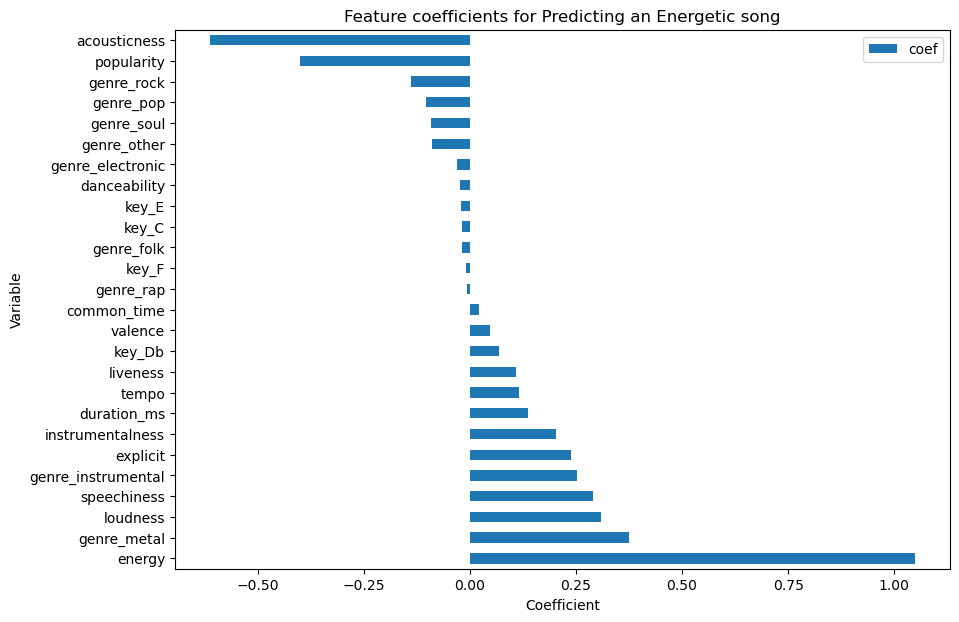

,Model,Dataset,train_score,test_score
0,baseline_raw,EC,0.761717,0.761137
1,baseline_raw,HS,0.612460,0.615771
2,baseline_preproc,EC,0.820935,0.802937
3,baseline_preproc,HS,0.689941,0.675709
4,optimised,EC,0.820676,0.801369
5,optimised,HS,0.690409,0.674285
6,combined_optimised,EC,0.820827,0.802442


In [275]:
#instantiate pipeline

estimators = [('normalise', StandardScaler()),
            ('model', LogisticRegression(solver='lbfgs',penalty = 'l2', C = 0.0025, max_iter=20))]

ec_pipe = Pipeline(estimators)
joblib.dump(ec_pipe, "./data/pickles/EC_model_pipeline.pkl") #pickle the pipeline for use later

# fit and score model
ec_pipe.fit(X_train_ec, y_train_ec)
ec_train_score = ec_pipe.score(X_train_ec, y_train_ec)
ec_test_score = ec_pipe.score(X_test_ec, y_test_ec)

# put coefficient results in a dataframe for plotting

logreg_model = ec_pipe.named_steps['model'] # retrieve the logistic regression model from the pipeline
ec_features_df = pd.DataFrame()
ec_features_df['features'] = X_train_ec.columns
ec_features_df['coef'] = logreg_model.coef_[0]

ec_coefficients = ec_features_df.sort_values(by='coef', ascending=False).reset_index(drop=True)

# plot the coefficients
plt.figure(figsize=(10, 7))
ec_coefficients.plot(kind='barh', x='features', ax=plt.gca())
plt.title('Feature coefficients for Predicting an Energetic song')
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.show()

# add score to results dataframe
new_rowlist = ["combined_optimised", 'EC', ec_train_score, ec_test_score]
results_df.loc[len(results_df)] = new_rowlist
results_df

With our combined optimised model we have achieved a train accuracy of 82.1% and test accuracy of 80.2%.  Very similar to our preprocessed baseline.  We can therefore say our baseline was a good model, and we have achieved a similar accuracy despite dropping 9 features.

Create absolute value of coefficient for sorting and convert to an odds change

In [276]:
ec_coefficients['abs_coef'] = np.abs(ec_coefficients['coef'])
ec_coefficients['odds_change'] = np.exp(ec_coefficients['abs_coef'])
ec_coefficients.sort_values(by='abs_coef', ascending=False)

,features,coef,abs_coef,odds_change
0,energy,1.048060,1.048060,2.852112
25,acousticness,-0.611690,0.611690,1.843544
24,popularity,-0.400835,0.400835,1.493072
1,genre_metal,0.374736,0.374736,1.454608
2,loudness,0.310252,0.310252,1.363769
3,speechiness,0.289920,0.289920,1.336321
4,genre_instrumental,0.252860,0.252860,1.287703
5,explicit,0.237978,0.237978,1.268681
6,instrumentalness,0.202571,0.202571,1.224547
23,genre_rock,-0.139351,0.139351,1.149528


The coefficients above relate to the odds changes from the different variables in our model.

To translate these into real terms:

**The odds change for each feature can be interpreted as the change in likelihood of a song being energetic, given a 1 standard deviation increase.**

Where the coefficient is negative, the odds change equates to a decrease in likelihood.

#### Happy/Sad

Select the combined feature set

In [277]:
X_train_hs = X_train_hs[ec_hs_features]
X_test_hs = X_test_hs[ec_hs_features]

In [278]:
# estimators = [('normalise', StandardScaler()),
#               # we don't need the selectKBest anymore
#               ('model', LogisticRegression())]

# pipe = Pipeline(estimators)

# c_list = [0.005, 0.0075, 0.01, 0.025, 0.05]

# param_grid = [
#             {'normalise': [StandardScaler()],
#              'model': [LogisticRegression(n_jobs=-1)],
#              'model__max_iter': [50, 75, 100, 200],
#              'model__solver': ['liblinear', 'lbfgs'],
#              'model__penalty': ['l1','l2'],
#              'model__C': c_list}]

# grid = GridSearchCV(pipe, param_grid, cv=5)
# fittedgrid = grid.fit(X_train_hs, y_train_hs)

# joblib.dump(fittedgrid, "./data/pickles/HS_model_comb_gs.pkl")

In [279]:
fittedgrid = joblib.load("./data/pickles/HS_model_comb_gs.pkl")

In [280]:
bestparams = fittedgrid.best_params_
bestparams['score (%)'] = round(fittedgrid.best_score_*100, 3)
bestparams['classification'] = fittedgrid.classes_[1]
params_df2 = pd.DataFrame(data=bestparams, index=[0])
params_df = pd.concat([params_df, params_df2], axis=0)
params_df

,model,model__C,model__penalty,model__solver,normalise,reduce_dim,reduce_dim__k,reduce_dim__score_func,score (%),classification,model__max_iter
0,"LogisticRegression(C=0.01, n_jobs=-1)",0.0100,l2,lbfgs,StandardScaler(),SelectKBest(k=33),33.0,<function f_classif at 0x0000019275033370>,82.072,energetic,NaN
0,"LogisticRegression(C=0.001, n_jobs=-1)",0.0010,l2,lbfgs,StandardScaler(),SelectKBest(k=17),17.0,<function f_classif at 0x0000019275033370>,82.009,energetic,NaN
0,"LogisticRegression(C=0.005, n_jobs=-1)",0.0050,l2,lbfgs,StandardScaler(),SelectKBest(k=19),19.0,<function f_classif at 0x0000019275033370>,82.040,energetic,NaN
0,"LogisticRegression(C=0.0025, n_jobs=-1)",0.0025,l2,lbfgs,StandardScaler(),SelectKBest(k=20),20.0,<function f_classif at 0x0000019275033370>,82.046,energetic,NaN
0,"LogisticRegression(C=0.0025, max_iter=3, n_job...",0.0025,l2,sag,StandardScaler(),SelectKBest(k=20),20.0,<function f_classif at 0x0000019275033370>,82.091,energetic,3.0
0,"LogisticRegression(C=0.0025, max_iter=10, n_jo...",0.0025,l2,lbfgs,StandardScaler(),SelectKBest(k=20),20.0,<function f_classif at 0x0000019275033370>,82.050,energetic,10.0
0,"LogisticRegression(C=0.1, n_jobs=-1, solver='l...",0.1000,l2,liblinear,MinMaxScaler(),SelectKBest(k=30),30.0,<function f_classif at 0x0000019275033370>,68.994,sad,NaN
0,"LogisticRegression(C=0.01, n_jobs=-1, penalty=...",0.0100,l1,liblinear,StandardScaler(),SelectKBest(k=25),25.0,<function f_classif at 0x0000019275033370>,68.981,sad,NaN
0,"LogisticRegression(C=0.01, n_jobs=-1, penalty=...",0.0100,l1,liblinear,StandardScaler(),SelectKBest(k=24),24.0,<function f_classif at 0x0000019275033370>,68.990,sad,NaN
0,"LogisticRegression(C=0.01, max_iter=75, n_jobs...",0.0100,l1,liblinear,StandardScaler(),SelectKBest(k=24),24.0,<function f_classif at 0x0000019275033370>,68.990,sad,75.0


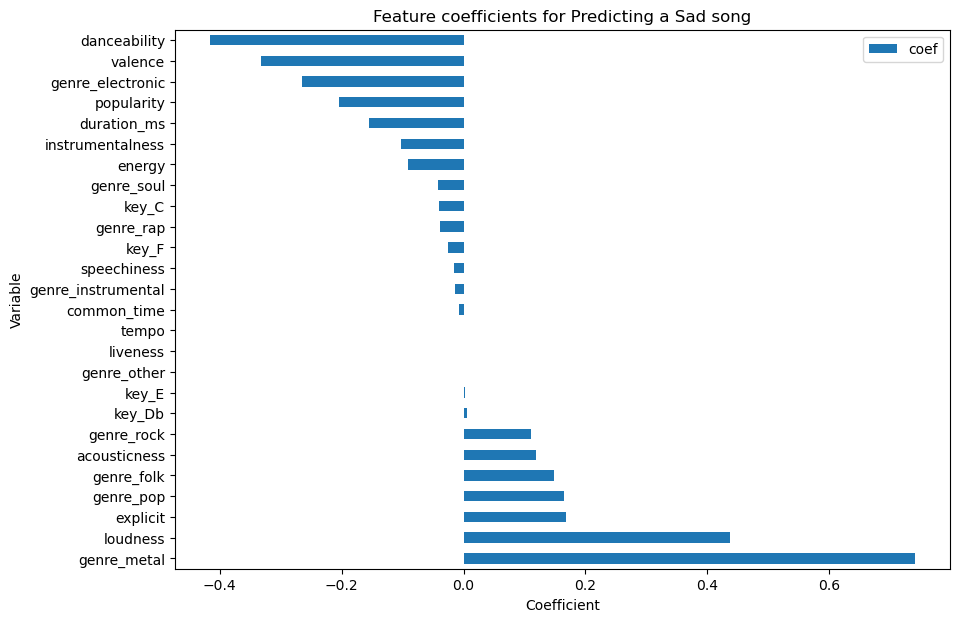

,Model,Dataset,train_score,test_score
0,baseline_raw,EC,0.761717,0.761137
1,baseline_raw,HS,0.612460,0.615771
2,baseline_preproc,EC,0.820935,0.802937
3,baseline_preproc,HS,0.689941,0.675709
4,optimised,EC,0.820676,0.801369
5,optimised,HS,0.690409,0.674285
6,combined_optimised,EC,0.820827,0.802442
7,combined_optimised,HS,0.689230,0.675505


In [281]:
#instantiate pipeline

estimators = [('normalise', StandardScaler()),
            ('model', LogisticRegression(solver='liblinear',penalty = 'l1', C = 0.01, max_iter=75))]

hs_pipe = Pipeline(estimators)
joblib.dump(hs_pipe, "./data/pickles/HS_model_pipeline.pkl") #pickle the pipeline for use later

# fit and score model
hs_pipe.fit(X_train_hs, y_train_hs)
hs_train_score = hs_pipe.score(X_train_hs, y_train_hs)
hs_test_score = hs_pipe.score(X_test_hs, y_test_hs)

# put coefficient results in a dataframe for plotting

logreg_model = hs_pipe.named_steps['model'] # retrieve the logistic regression model from the pipeline
hs_features_df = pd.DataFrame()
hs_features_df['features'] = X_train_hs.columns
hs_features_df['coef'] = logreg_model.coef_[0]

hs_coefficients = hs_features_df.sort_values(by='coef', ascending=False).reset_index(drop=True)

# plot the coefficients
plt.figure(figsize=(10, 7))
hs_coefficients.plot(kind='barh', x='features', ax=plt.gca())
plt.title('Feature coefficients for Predicting a Sad song')
plt.xlabel('Coefficient')
plt.ylabel('Variable')
plt.show()

# add score to results dataframe
new_rowlist = ["combined_optimised", 'HS', hs_train_score, hs_test_score]
results_df.loc[len(results_df)] = new_rowlist
results_df

With our combined optimised model we have achieved a train accuracy of 68.9% and test accuracy of 67.5%.  Very similar to our preprocessed baseline.  We can therefore say our baseline was a good model, and we have achieved a similar accuracy despite dropping 9 features.

In [282]:
hs_coefficients['abs_coef'] = np.abs(hs_coefficients['coef'])
hs_coefficients['odds_change'] = np.exp(hs_coefficients['abs_coef'])
hs_coefficients.sort_values(by='abs_coef', ascending=False)

,features,coef,abs_coef,odds_change
0,genre_metal,0.740659,0.740659,2.097318
1,loudness,0.436719,0.436719,1.547621
25,danceability,-0.415950,0.415950,1.515810
24,valence,-0.332264,0.332264,1.394121
23,genre_electronic,-0.264951,0.264951,1.303368
22,popularity,-0.205056,0.205056,1.227594
2,explicit,0.169029,0.169029,1.184155
3,genre_pop,0.164329,0.164329,1.178602
21,duration_ms,-0.154805,0.154805,1.167430
4,genre_folk,0.147885,0.147885,1.159380


The coefficients above relate to the odds changes from the different variables in our model.

To translate these into real terms:

**The odds change for each feature can be interpreted as the change in likelihood of a song being sad, given a 1 standard deviation increase.**

Where the coefficient is negative, the odds change equates to a decrease in likelihood.